# Packages

In [1]:
using CSV, DataFrames

In [2]:
using FixedEffectModels

LoadError: ArgumentError: Package FixedEffectModels not found in current path.
- Run `import Pkg; Pkg.add("FixedEffectModels")` to install the FixedEffectModels package.

In [3]:
using Plots

In [4]:
using Statistics

# Uploading CPS data

In [5]:
cps = DataFrame(CSV.File("c:\\data\\Bounds\\cps.csv")) # <-change this to the right directory

## Cleaning zero wage

cps = cps[cps.wage .> 0, :]
first(cps,5)

Row,age,wage,educ
,Int64,Int64,String
1,22,12000,some college but no degree
2,21,3500,some college but no degree
3,49,30000,some college but no degree
4,31,32000,bachelor's degree
5,42,89630,doctorate degree


In [6]:
# Numerical value for education

#1.Creating a dictionary

educ_dict = Dict( 
    "grade 11" => 11, 
    "some college but no degree" => 13, 
    "associate's degree, academic program" => 14,
    "grade 10" => 10, 
    "grades 7 or 8" => 8, 
    "grades 1, 2, 3, or 4" => 4, 
    "associate's degree, occupational/vocational program" => 14, 
    "high school diploma or equivalent" => 12, 
    "grade 9" => 9, 
    "none or preschool" => 0, 
    "doctorate degree" => 21,
    "bachelor's degree" => 16, 
    "master's degree" => 14, 
    "grades 5 or 6" => 6, 
    "professional school degree" => 14, 
    "12th grade, no diploma" => 12
    )

Dict{String, Int64} with 16 entries:
  "grade 11"                                            => 11
  "some college but no degree"                          => 13
  "associate's degree, academic program"                => 14
  "none or preschool"                                   => 0
  "doctorate degree"                                    => 21
  "grade 10"                                            => 10
  "bachelor's degree"                                   => 16
  "master's degree"                                     => 14
  "grades 5 or 6"                                       => 6
  "grades 7 or 8"                                       => 8
  "grades 1, 2, 3, or 4"                                => 4
  "associate's degree, occupational/vocational program" => 14
  "professional school degree"                          => 14
  "high school diploma or equivalent"                   => 12
  "grade 9"                                             => 9
  "12th grade, no diploma"            

In [7]:
#2. transforming cps.educ
f(x) = educ_dict[x]
cps.educ_num = f.(cps.educ)

#3. log of wage
cps.log_wage = log.(cps.wage)
first(cps,3)

Row,age,wage,educ,educ_num,log_wage
,Int64,Int64,String,Int64,Float64
1,22,12000,some college but no degree,13,9.39266
2,21,3500,some college but no degree,13,8.16052
3,49,30000,some college but no degree,13,10.309


In [8]:
Nobs, c = size(cps)
print("The original data contains ", Nobs, " observations and ",c, " columns.")

The original data contains 22715 observations and 5 columns.

# Best Linear Predictor 

In [9]:
#reg(cps, @formula(log_wage ~ educ_num ), Vcov.robust())

In [10]:
#reg(cps, @formula(log_wage ~ educ_num + age ), Vcov.robust())

# Creating Interval Data

In [11]:
wage_quantiles = quantile(cps[!,:wage],[0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], sorted=false);
#wage_quantiles[1] +=-1
wage_quantiles[end] +=1

362303.0

In [12]:
lower(x) = wage_quantiles[sum(wage_quantiles .<=x)]
upper(x) = wage_quantiles[sum(wage_quantiles .<=x)+1]

cps.wage_lower = lower.(cps.wage)
cps.wage_upper = upper.(cps.wage)

cps.logwage_lower = log.(cps.wage_lower)
cps.logwage_upper = log.(cps.wage_upper)

first(cps,3)

Row,age,wage,educ,educ_num,log_wage,wage_lower,wage_upper,logwage_lower,logwage_upper
,Int64,Int64,String,Int64,Float64,Float64,Float64,Float64,Float64
1,22,12000,some college but no degree,13,9.39266,9000.0,15000.0,9.10498,9.61581
2,21,3500,some college but no degree,13,8.16052,1.0,9000.0,0.0,9.10498
3,49,30000,some college but no degree,13,10.309,30000.0,36000.0,10.309,10.4913


In [13]:
Nobs, c = size(cps)
print("The complete data contains ", Nobs, " observations and ",c, " columns.")

The complete data contains 22715 observations and 9 columns.

# Partial Indentification

### Reading the module

In [14]:
include("C:\\Users\\arie\\OneDrive - University of Pittsburgh\\Documents\\Bounds.jl\\Bounds.jl\\src\\setBLP.jl")

Main.setBLP

In [15]:
using Main.setBLP

## Testing projection function

In [16]:
methods(projection)

# 7 methods for generic function "projection" from Main.setBLP:
 [1] projection(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Vector{<:Real})
     @ C:\Users\arie\OneDrive - University of Pittsburgh\Documents\Bounds.jl\Bounds.jl\src\setBLP.jl:199
 [2] projection(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Matrix{<:Real})
     @ C:\Users\arie\OneDrive - University of Pittsburgh\Documents\Bounds.jl\Bounds.jl\src\setBLP.jl:240
 [3] projection(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Matrix{<:Real}, cord::Int64)
     @ C:\Users\arie\OneDrive - University of Pittsburgh\Documents\Bounds.jl\Bounds.jl\src\setBLP.jl:210
 [4] projection(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Matrix{<:Real}, cords::Vector{Int64})
     @ C:\Users\arie\OneDrive - University of Pittsburgh\Documents\Bounds.jl\Bounds.jl\src\setBLP.jl:223
 [5] projection(df::DataFrame, yl::Symbol, yu::Symbol, x::Symbol)
     @ C:\Users\arie\OneDrive - University of Pittsburgh\Documents\Bounds.jl\Bounds.jl\src\setBLP.jl:258
 [6] projection(df::DataFrame, yl::Symbol, yu::Symbol, x::Vector{Symbol})
     @ C:\Users\arie\OneDrive - University of Pittsburgh\Documents\Bounds.jl\Bounds.jl\src\setBLP.jl:266
 [7] projection(df::DataFrame, yl::Symbol, yu::Symbol, x::Vector{Symbol}, cord::Int64)
     @ C:\Users\arie\OneDrive - University of Pittsburgh\Documents\Bounds.jl\Bounds.jl\src\setBLP.jl:274

In [17]:
show(default_options)

Options:
  Number of MC iterations: 2000
  Seed: 15217
  Random Number Generator: Random.MersenneTwister(0x8e1986c77bf649e30e3623d14baf3374)
  Confidence level: 0.95


### 1. Testing the vector/matrix functions

In [18]:
# Preparing vector and matrix versions of the data

yl = cps.logwage_lower;
yu = cps.logwage_upper;
x1 = cps.age;
x2 = cps.educ_num;
x = [x1 x2];

In [19]:
#projection(yl,yu,x1)

In [20]:
#projection(yl,yu,x1)

In [21]:
projection(yl,yu,x,1)

1×2 Matrix{Float64}:
 -0.00905178  0.144324

In [22]:
#projection(yl,yu,x,2)

In [23]:
#projection(yl,yu,x)

### 2. Testing the Dataframe version of the functions

In [24]:
projection(cps,:logwage_lower,:logwage_upper,:age)

1×2 Matrix{Float64}:
 -0.00488786  0.14866

In [25]:
#projection(cps,:logwage_lower,:logwage_upper,:educ_num)

In [26]:
#projection(cps,:logwage_lower,:logwage_upper,[:age,:educ_num],1)

In [27]:
#projection(cps,:logwage_lower,:logwage_upper,[:age,:educ_num],2)

In [28]:
#projection(cps,:logwage_lower,:logwage_upper,[:age,:educ_num])

## Testing oneDproj function

In [29]:
res = oneDproj(yl,yu,float.(x1);CI=true,H0=[0, 0.15]);
show(res)

Results: 
  Null: [0.0, 0.15]
  Bound: [-0.0049, 0.1487]
  Hausdorff based test: 
    Test Stat: 0.7367
    Critical Value: 0.72
    Confidence Interval: [-0.0097, 0.1534]
  directed Hausdorff test: 
    Test Stat: 0.202
    Critical Value: 0.6101
    Confidence Interval: [-0.0089, 0.1527]


In [30]:
res = oneDproj(yl,yu,float.(x1);CI=true,H0=[0.1,0.15]);
show(res)

Results: 
  Null: [0.1, 0.15]
  Bound: [-0.0049, 0.1487]
  Hausdorff based test: 
    Test Stat: 15.8082
    Critical Value: 0.7131
    Confidence Interval: [-0.0096, 0.1534]
  directed Hausdorff test: 
    Test Stat: 0.202
    Critical Value: 0.6069
    Confidence Interval: [-0.0089, 0.1527]


In [31]:
res = oneDproj(yl,yu,float.(x1);CI=true,H0=[0.0,0.1]);
show(res)

Results: 
  Null: [0.0, 0.1]
  Bound: [-0.0049, 0.1487]
  Hausdorff based test: 
    Test Stat: 7.3337
    Critical Value: 0.7344
    Confidence Interval: [-0.0098, 0.1535]
  directed Hausdorff test: 
    Test Stat: 0.0
    Critical Value: 0.6269
    Confidence Interval: [-0.009, 0.1528]


In [32]:
res = oneDproj(yl,yu,float.(x1);CI=true,H0=[-0.1,0.15]);
show(res)

Results: 
  Null: [-0.1, 0.15]
  Bound: [-0.0049, 0.1487]
  Hausdorff based test: 
    Test Stat: 14.3348
    Critical Value: 0.7108
    Confidence Interval: [-0.0096, 0.1534]
  directed Hausdorff test: 
    Test Stat: 14.3348
    Critical Value: 0.6118
    Confidence Interval: [-0.0089, 0.1527]


In [33]:
res = oneDproj(yl,yu,float.(x1);CI=false,H0=nothing)

Results([-0.004887858329799178, 0.14865963017399053], nothing, nothing, nothing)

In [34]:
res = oneDproj(yl,yu,real.(x1))

Results([-0.004887858329799178, 0.14865963017399053], nothing, TestResults([-0.009558259654662083, 0.15333003149885344], 0.703899361754869, nothing), TestResults([-0.008794465649276323, 0.15256623749346768], 0.588784176676205, nothing))

In [35]:
res = oneDproj(cps,:logwage_lower,:logwage_upper,:educ_num)

Results([0.001786042221944126, 0.3685793555817362], nothing, TestResults([-0.014275130914976111, 0.38464052871865645], 2.4206591112262634, nothing), TestResults([-0.011558989546673606, 0.38192438735035394], 2.0112959660493868, nothing))

### Plotting

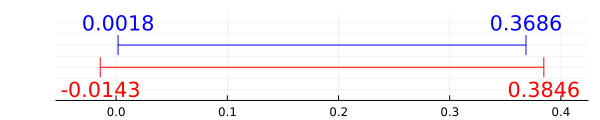

In [36]:
x = [res.Htest.ConfidenceInterval[1],res.bound[1],res.bound[2],res.Htest.ConfidenceInterval[2]]
tol = (x[4]-x[1])/10
y =[-0.01,0.01,0.01,-0.01]
symbols =[:vline,:vline,:vline,:vline]

scatter(x, y, markersize=10,
    xlim=(x[1]-tol,x[4]+tol),
    ylim=(-0.04,0.04),
    markershape=symbols,
    markerstrokewidth=4,
    label="",
    c=[:red,:blue,:blue,:red],
    showaxis=:x,
    size =(600,120))
plot!(x[2:3],y[2:3],label="",c=:blue)
plot!(x[1:3:4],y[1:3:4],label="",c=:red)
annotate!(x[2], 0.03, string(round(x[2],digits=4)),:blue)
annotate!(x[3], 0.03, string(round(x[3],digits=4)),:blue)
annotate!(x[1], -0.03, string(round(x[1],digits=4)),:red)
annotate!(x[4], -0.03, string(round(x[4],digits=4)),:red)


In [37]:
show(EY(yl,yu,[1,2]))

Results: 
  Null: [1.0, 2.0]
  Bound: [9.2963, 10.5299]
  Hausdorff based test: 
    Test Stat: 1285.5883
    Critical Value: 5.9938
    Confidence Interval: [9.2566, 10.5697]
  directed Hausdorff test: 
    Test Stat: 1250.3817
    Critical Value: 4.9193
    Confidence Interval: [9.2637, 10.5626]


In [38]:
show(EY(yl,yu,[9.2963, 10.5299]))

Results: 
  Null: [9.2963, 10.5299]
  Bound: [9.2963, 10.5299]
  Hausdorff based test: 
    Test Stat: 0.0051
    Critical Value: 5.9938
    Confidence Interval: [9.2566, 10.5697]
  directed Hausdorff test: 
    Test Stat: 0.0051
    Critical Value: 4.9193
    Confidence Interval: [9.2637, 10.5626]


In [39]:
show(default_options)

Options:
  Number of MC iterations: 2000
  Seed: 15217
  Random Number Generator: Random.MersenneTwister(0x8e1986c77bf649e30e3623d14baf3374, (0, 341133144, 0, 0, 341131890, 930))
  Confidence level: 0.95


In [40]:
show(EY(yl,yu,[1,2];options=default_options,method="boot"))

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mFloat64[39m[0m to an object of type 
[0m  [91mVector{<:Real}[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::AbstractArray[39m) where T<:Array
[0m[90m   @[39m [90mBase[39m [90m[4marray.jl:613[24m[39m
[0m  convert(::Type{T}, [91m::LinearAlgebra.Factorization[39m) where T<:AbstractArray
[0m[90m   @[39m [36mLinearAlgebra[39m [90mC:\Users\arie\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\LinearAlgebra\src\[39m[90m[4mfactorization.jl:59[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T<:AbstractArray
[0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:16[24m[39m
[0m  ...


In [41]:
default_options

Options(2000, 15217, Random.MersenneTwister(0x8e1986c77bf649e30e3623d14baf3374, (0, 397989504, 0, 0, 397988250, 250)), 0.95)